In [1]:
using LinearAlgebra
using FFTW, AbstractFFTs
using StaticArrays
using YAML
using JLD2
using Strided

using PyPlot
using PyCall

plt.style.use("dark_mode")
mpl = pyimport("matplotlib")
np = pyimport("numpy")
@pyimport mpl_toolkits.axes_grid1 as axgrid

In [2]:
function wavevectors3D(T::Type{<:Real}, dims, box_size=(2π, 2π, 2π))
    sample_rate = T.(2π .* dims ./ box_size)
    kx = fftfreq(dims[1], sample_rate[1]) .* (2π / dims[1])
    ky = fftfreq(dims[2], sample_rate[2]) .* (2π / dims[2])
    kz = fftfreq(dims[3], sample_rate[3]) .* (2π / dims[3])
    return kx, ky, kz
end



"""
Computes the Fourier representation of a Gaussian filter with width ``R_S``.
You would multiply this with the FFT'd field and then IFFT to apply the filter.

# Arguments:
- `R_S::T`: filter radius
- `kv`: wavevector, tuple of (kx, ky, kz)

# Returns:
- `Array{T,3}`: fourier representation of gaussian filter
"""
function kspace_gaussian_filter(R_S::T, kv) where T
    kx, ky, kz = kv
    nx, ny, nz = length(kx), length(ky), length(kz)
    filter_k = zeros(T, (nx, ny, nz))
    Threads.@threads for ix = 1:nx
        for iy = 1:ny, iz = 1:nz
            filter_k[ix, iy, iz] = exp(
                -(kx[ix]^2 + ky[iy]^2 + kz[iz]^2) * R_S^2 / 2)
        end
    end
    return filter_k
end


"""
Apply a gaussian filter to a density field with smoothing radius `R_S`
making use of wavevectors `kv`

# Arguments:
- `f::AbstractArray{T,3}`: density field
- `R_S::T`: filter radius
- `kv`: wavevector, tuple of (kx, ky, kz)

# Returns:
- Array{T,3}: smoothed density field
"""
function smooth_gauss(f::AbstractArray{T,3}, R_S::T, kv) where T

    GF = kspace_gaussian_filter(R_S, kv)  # get filter in Fourier space
    f_Rn = (real(ifft(GF .* fft(f))))
    f_Rn = f_Rn .* (sum(f)/sum(f_Rn))  # normalize
    return f_Rn
end


"""
Apply a gaussian filter to a density field with smoothing radius `R_S`
making use of wavevectors `kv` using log smoothing

# Arguments:
- `f::AbstractArray{T,3}`: density field
- `R_S::T`: filter radius
- `kv`: wavevector, tuple of (kx, ky, kz)

# Returns:
- Array{T,3}: log-smoothed density field
"""
function smooth_loggauss(f::AbstractArray{T,3}, R_S::T, kv) where {AA, T}
    # get filter in Fourier space
    GF = kspace_gaussian_filter(R_S, kv)

    # # simple version of what follows
    # f_Rn = 10 .^(real(ifft(GF .* fft(log10.(f)))))

    buffer = similar(f, Complex{T})   # make a complex version of the array
    @strided buffer .= log10.(f)      # threaded log10 the entire array
    fft!(buffer)                      # FFT
    @strided buffer .= GF .* buffer   # convolve
    ifft!(buffer)                     # IFFT
    f_result = real(buffer)           # get the real part
    @strided f_result .= (10 .^ f_result)  # threaded exp
    norm = sum(f)/sum(f_result)       # compute normalization
    @strided f_result .= f_result .* norm  # normalize
    return f_result
end



smooth_loggauss

In [3]:
function cylinder(n::Int64,r::Float64)
    """
    Returns a nxnxn array with a cylinder in the center with
    radius r. All points within the radius are = 1, the rest
    are 0.
    """
    array  = zeros(Float64,(n,n,n))
    array[:,:,:] .= 0.1
    for x::Int64 in 1:n
        for y::Int64 in 1:n
            for z::Int64 in 1:n
                if ((x - (n)/2)^2 + (y - (n)/2)^2) < r^2
                    array[x,y,z] = 1
                end
            end
        end
    end
    return array
end

cylinder (generic function with 1 method)

In [4]:
n = 100
kv = (n,n,n)
Rs = 0.01
density_field = ( cylinder(n, 10.0) .* 100 ) .+ 0.001
density_field_smoothed = smooth_loggauss(density_field, Rs, kv)
wave_vecs = wavevectors3D(Float64,kv)

print("initialize density field")

initialize density field

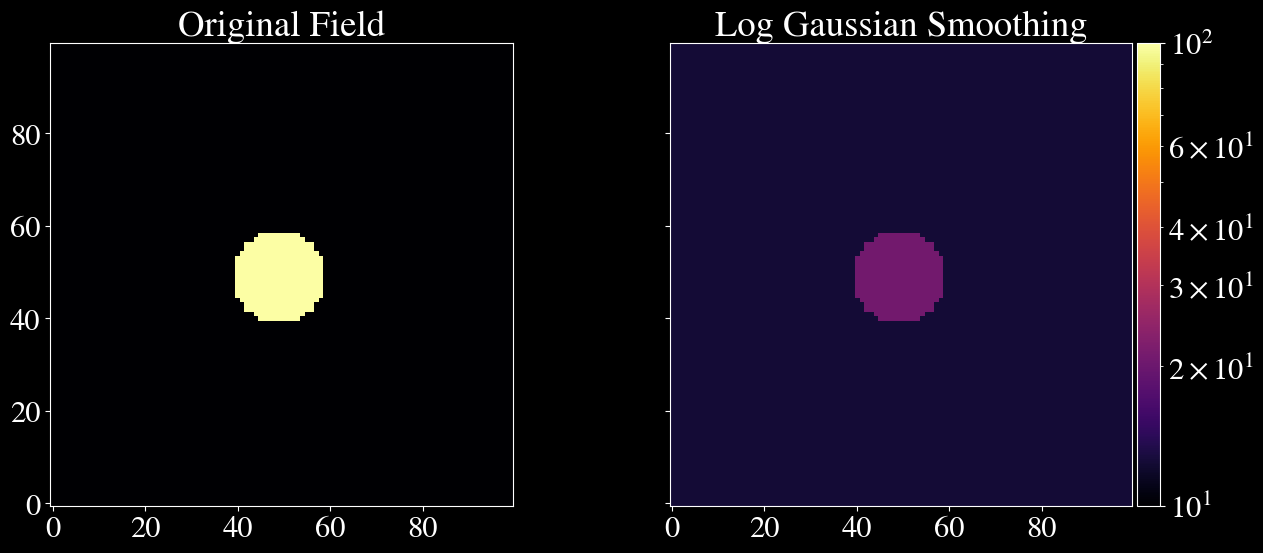

In [5]:
f, axes = plt.subplots(1,2,sharey=true, figsize=(14,6))
axes[1].set_title("Original Field")
im1 = axes[1].imshow(density_field[:,:,50], origin="lower", cmap="inferno", norm=mpl.colors.LogNorm(vmin=10, vmax=100.0))
divider1 = axgrid.make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cax1.set_axis_off()


axes[2].set_title("Log Gaussian Smoothing")
im3 = axes[2].imshow(density_field_smoothed[:,:,50], origin="lower", cmap="inferno", norm=mpl.colors.LogNorm(vmin=10, vmax=100.0))
divider3 = axgrid.make_axes_locatable(axes[2])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im3, cax=cax3)
f.tight_layout()

In [6]:
function slow_hessian_from_smoothed(f_Rn::AbstractArray{T,3}, R_S, kv) where T
    dims = size(f_Rn)
    hessian = zeros(Complex{T}, (dims[1], dims[2], dims[3], 6))
    f_Rn_hat = fft(f_Rn)

    kx = kv[1]
    ky = kv[2]
    kz = kv[3]

    Threads.@threads for x in 1:length(kv[1])
        for y in 1:length(kv[2])
            for z in 1:length(kv[3])
                # (1,1)
                hessian[x,y,z,1] =
                    - kx[x] * kx[x] * R_S^2 * f_Rn_hat[x,y,z]
                # (1,2)
                hessian[x,y,z,2] =
                    - kx[x] * ky[y] * R_S^2 * f_Rn_hat[x,y,z]
                # (1,3)
                hessian[x,y,z,3] =
                    - kx[x] * kz[z] * R_S^2 * f_Rn_hat[x,y,z]
                # (2,2)
                hessian[x,y,z,4] =
                    - ky[y] * ky[y] * R_S^2 * f_Rn_hat[x,y,z]
                # (2,3)
                hessian[x,y,z,5] =
                    - ky[y] * kz[z] * R_S^2 * f_Rn_hat[x,y,z]
                # (3,3)
                hessian[x,y,z,6] =
                    - kz[z] * kz[z] * R_S^2 * f_Rn_hat[x,y,z]
            end
        end
    end
    hessian[:,:,:,1] .= ifft(hessian[:,:,:,1])
    hessian[:,:,:,2] .= ifft(hessian[:,:,:,2])
    hessian[:,:,:,3] .= ifft(hessian[:,:,:,3])
    hessian[:,:,:,4] .= ifft(hessian[:,:,:,4])
    hessian[:,:,:,5] .= ifft(hessian[:,:,:,5])
    hessian[:,:,:,6] .= ifft(hessian[:,:,:,6])
    real(R_S^2 .* hessian)
end

slow_hessian_from_smoothed (generic function with 1 method)

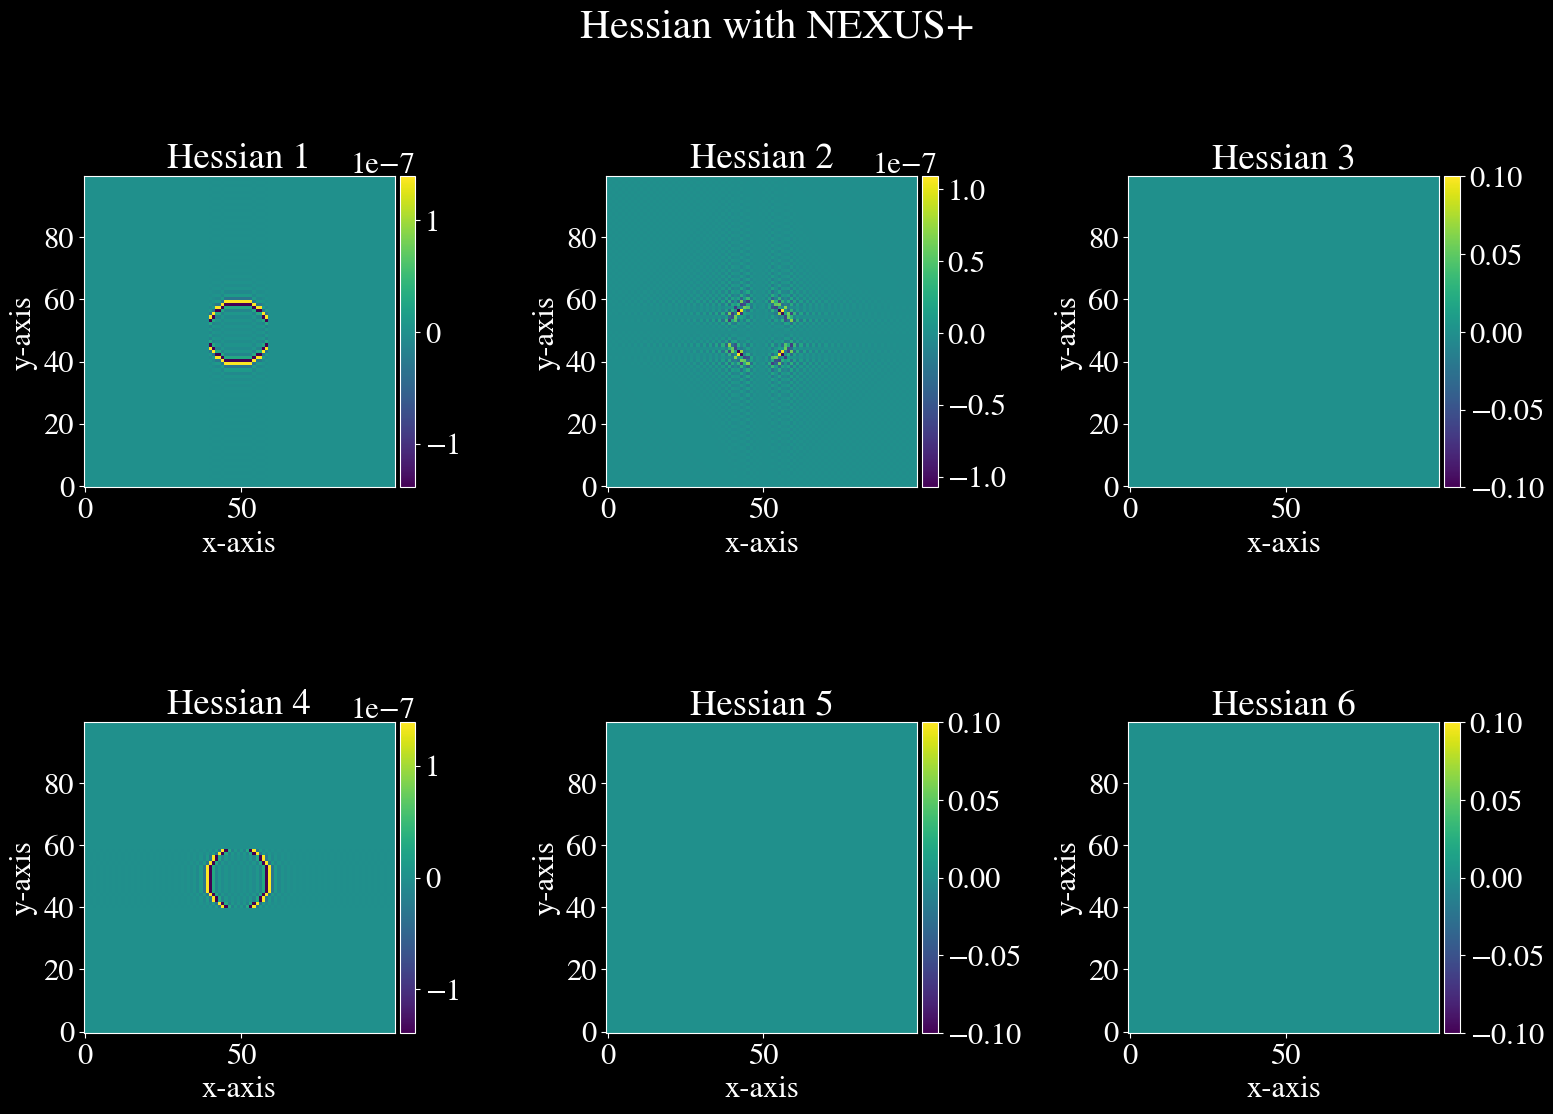

In [7]:
hess_slow = slow_hessian_from_smoothed(density_field_smoothed, Rs, wave_vecs)

Hessian_TNG = hess_slow


f = plt.figure(figsize=(16,12))
f.suptitle("Hessian with NEXUS+", fontsize=30)
#top left
ax1 = plt.subplot(231)
#plot_square(Hessian_TNG[:,:,128,1], ax=ax1)
#ax1.imshow(Hessian_TNG[:,:,128,1], origin="lower", vmin=-0.05, vmax=0.05)
ax1.set_title("Hessian 1")
ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")
im1 = ax1.imshow(Hessian_TNG[:,:,50,1], origin="lower")
divider1 = axgrid.make_axes_locatable(ax1)
cax1 = divider1[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
#top middle
ax2 = plt.subplot(232)
#plot_square(Hessian_TNG[:,:,128,2], ax=ax2)
# ax2.imshow(Hessian_TNG[:,:,128,2], origin="lower")
ax2.set_title("Hessian 2")
ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
im2 = ax2.imshow(Hessian_TNG[:,:,50,2], origin="lower")
divider2 = axgrid.make_axes_locatable(ax2)
cax2 = divider2[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
#top right
ax3 = plt.subplot(233)
#plot_square(Hessian_TNG[:,:,128,3], ax=ax3)
# ax3.imshow(Hessian_TNG[:,:,128,3], origin="lower")
ax3.set_title("Hessian 3")
ax3.set_xlabel("x-axis")
ax3.set_ylabel("y-axis")
im3 = ax3.imshow(Hessian_TNG[:,:,50,3], origin="lower")
divider3 = axgrid.make_axes_locatable(ax3)
cax3 = divider3[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)

#left
ax4 = plt.subplot(234)
#plot_square(Hessian_TNG[:,:,128,4], ax=ax4)
# ax4.imshow(Hessian_TNG[:,:,128,4], origin="lower")
ax4.set_title("Hessian 4")
ax4.set_xlabel("x-axis")
ax4.set_ylabel("y-axis")
im4 = ax4.imshow(Hessian_TNG[:,:,50,4], origin="lower")
divider4 = axgrid.make_axes_locatable(ax4)
cax4 = divider4[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im4, cax=cax4)
#middle
ax5 = plt.subplot(235)
#plot_square(Hessian_TNG[:,:,128,5], ax=ax5)
# ax5.imshow(Hessian_TNG[:,:,128,5], origin="lower")
ax5.set_title("Hessian 5")
ax5.set_xlabel("x-axis")
ax5.set_ylabel("y-axis")
im5 = ax5.imshow(Hessian_TNG[:,:,50,5], origin="lower")
divider5 = axgrid.make_axes_locatable(ax5)
cax5 = divider5[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im5, cax=cax5)
#right
ax6 = plt.subplot(236)
#plot_square(Hessian_TNG[:,:,128,6], ax=ax6)
# ax6.imshow(Hessian_TNG[:,:,128,6])
ax6.set_title("Hessian 6")
ax6.set_xlabel("x-axis")
ax6.set_ylabel("y-axis")
im6 = ax6.imshow(Hessian_TNG[:,:,50,6], origin="lower")
divider6 = axgrid.make_axes_locatable(ax6)
cax6 = divider6[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im6, cax=cax6)
plt.tight_layout()

In [8]:


function fast_hessian_from_smoothed(f_Rn::AbstractArray{T,3}, R_S, kv) where T
    dims = size(f_Rn)
    hessian = zeros(Complex{T}, (dims[1], dims[2], dims[3], 6))
    f_Rn_hat = fft(f_Rn)

    kx = kv[1]
    ky = kv[2]
    kz = kv[3]

    Threads.@threads for x in 1:length(kv[1])
        for y in 1:length(kv[2])
            for z in 1:length(kv[3])
                # (1,1)
                hessian[x,y,z,1] =
                    - kx[x] * kx[x] * R_S^2 * f_Rn_hat[x,y,z]
                # (1,2)
                hessian[x,y,z,2] =
                    - kx[x] * ky[y] * R_S^2 * f_Rn_hat[x,y,z]
                # (1,3)
                hessian[x,y,z,3] =
                    - kx[x] * kz[z] * R_S^2 * f_Rn_hat[x,y,z]
                # (2,2)
                hessian[x,y,z,4] =
                    - ky[y] * ky[y] * R_S^2 * f_Rn_hat[x,y,z]
                # (2,3)
                hessian[x,y,z,5] =
                    - ky[y] * kz[z] * R_S^2 * f_Rn_hat[x,y,z]
                # (3,3)
                hessian[x,y,z,6] =
                    - kz[z] * kz[z] * R_S^2 * f_Rn_hat[x,y,z]
            end
        end
    end

    for j in 1:6
        ifft!(@view (hessian[:,:,:,j]))
    end
    return real(R_S^2 .* hessian)
end



fast_hessian_from_smoothed (generic function with 1 method)

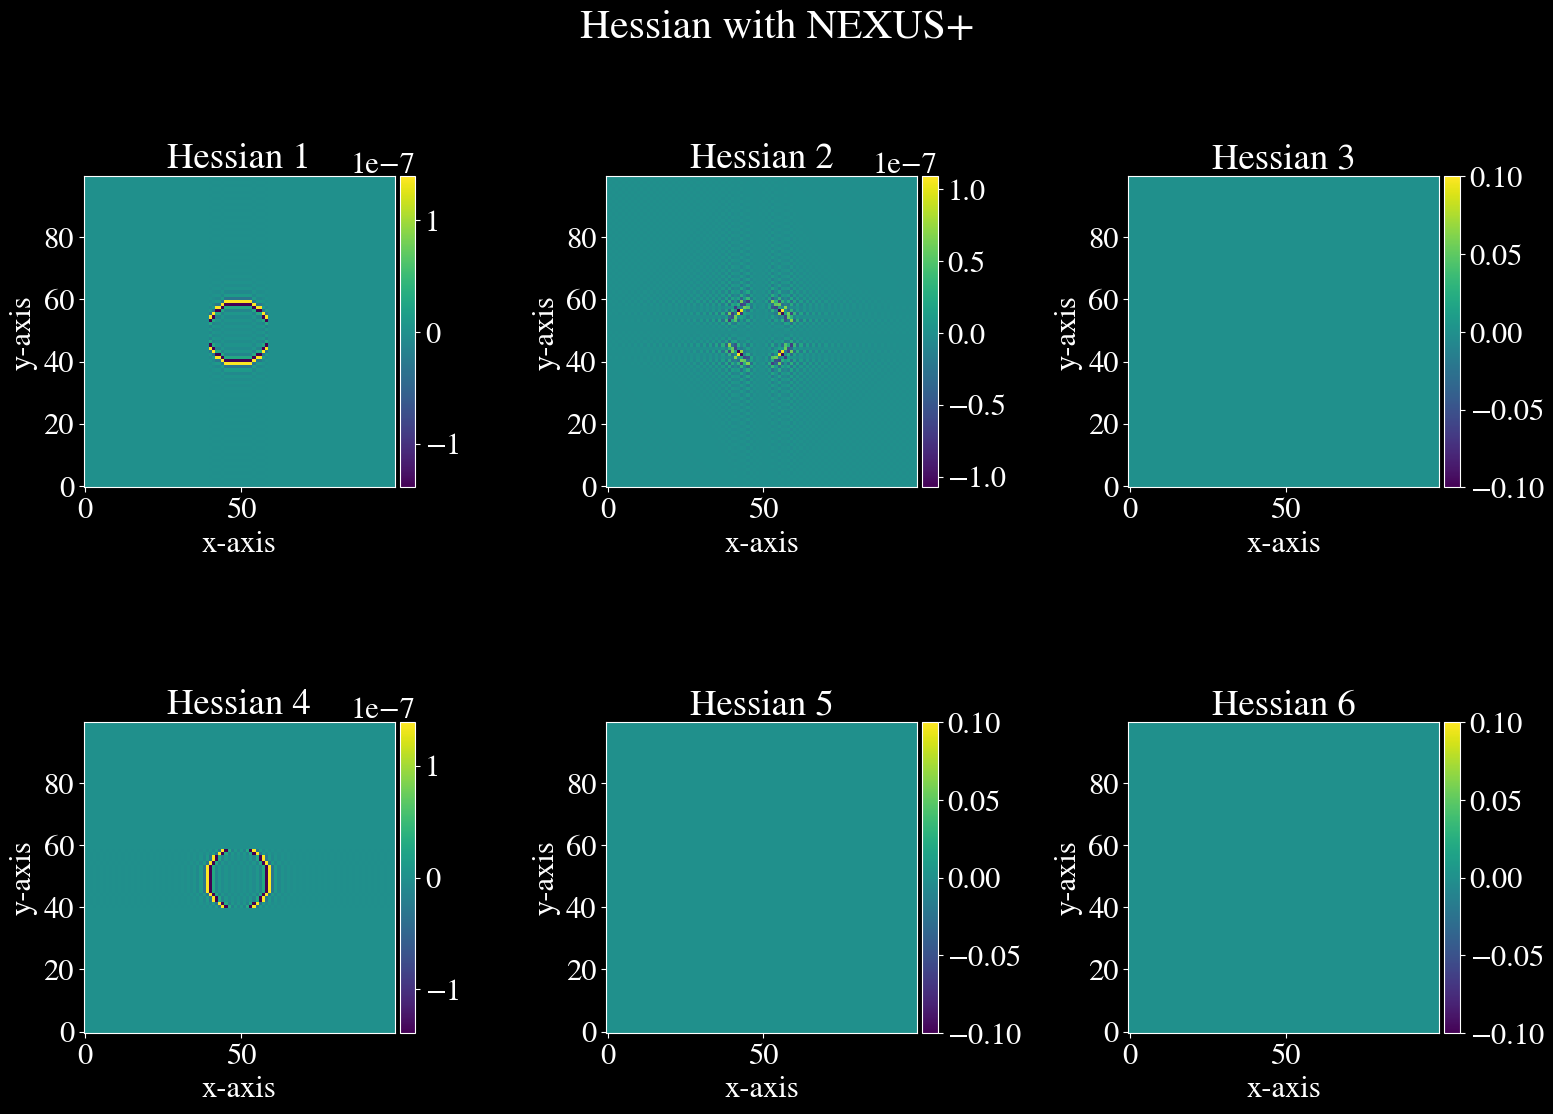

In [9]:
hess_fast  = fast_hessian_from_smoothed(density_field_smoothed, Rs, wave_vecs)

Hessian_TNG = hess_fast


f = plt.figure(figsize=(16,12))
f.suptitle("Hessian with NEXUS+", fontsize=30)
#top left
ax1 = plt.subplot(231)
#plot_square(Hessian_TNG[:,:,128,1], ax=ax1)
#ax1.imshow(Hessian_TNG[:,:,128,1], origin="lower", vmin=-0.05, vmax=0.05)
ax1.set_title("Hessian 1")
ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")
im1 = ax1.imshow(Hessian_TNG[:,:,50,1], origin="lower")
divider1 = axgrid.make_axes_locatable(ax1)
cax1 = divider1[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
#top middle
ax2 = plt.subplot(232)
#plot_square(Hessian_TNG[:,:,128,2], ax=ax2)
# ax2.imshow(Hessian_TNG[:,:,128,2], origin="lower")
ax2.set_title("Hessian 2")
ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
im2 = ax2.imshow(Hessian_TNG[:,:,50,2], origin="lower")
divider2 = axgrid.make_axes_locatable(ax2)
cax2 = divider2[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
#top right
ax3 = plt.subplot(233)
#plot_square(Hessian_TNG[:,:,128,3], ax=ax3)
# ax3.imshow(Hessian_TNG[:,:,128,3], origin="lower")
ax3.set_title("Hessian 3")
ax3.set_xlabel("x-axis")
ax3.set_ylabel("y-axis")
im3 = ax3.imshow(Hessian_TNG[:,:,50,3], origin="lower")
divider3 = axgrid.make_axes_locatable(ax3)
cax3 = divider3[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)

#left
ax4 = plt.subplot(234)
#plot_square(Hessian_TNG[:,:,128,4], ax=ax4)
# ax4.imshow(Hessian_TNG[:,:,128,4], origin="lower")
ax4.set_title("Hessian 4")
ax4.set_xlabel("x-axis")
ax4.set_ylabel("y-axis")
im4 = ax4.imshow(Hessian_TNG[:,:,50,4], origin="lower")
divider4 = axgrid.make_axes_locatable(ax4)
cax4 = divider4[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im4, cax=cax4)
#middle
ax5 = plt.subplot(235)
#plot_square(Hessian_TNG[:,:,128,5], ax=ax5)
# ax5.imshow(Hessian_TNG[:,:,128,5], origin="lower")
ax5.set_title("Hessian 5")
ax5.set_xlabel("x-axis")
ax5.set_ylabel("y-axis")
im5 = ax5.imshow(Hessian_TNG[:,:,50,5], origin="lower")
divider5 = axgrid.make_axes_locatable(ax5)
cax5 = divider5[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im5, cax=cax5)
#right
ax6 = plt.subplot(236)
#plot_square(Hessian_TNG[:,:,128,6], ax=ax6)
# ax6.imshow(Hessian_TNG[:,:,128,6])
ax6.set_title("Hessian 6")
ax6.set_xlabel("x-axis")
ax6.set_ylabel("y-axis")
im6 = ax6.imshow(Hessian_TNG[:,:,50,6], origin="lower")
divider6 = axgrid.make_axes_locatable(ax6)
cax6 = divider6[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im6, cax=cax6)
plt.tight_layout()

In [10]:
hess_slow == hess_fast

true

In [11]:
print("Hess Slow Calcualtion: ")
@time hess_slow = slow_hessian_from_smoothed(density_field_smoothed, Rs, wave_vecs)
print("\n")
print("Hess Fast Calcualtion: ")
@time hess_fast  = fast_hessian_from_smoothed(density_field_smoothed, Rs, wave_vecs)
print("\n")

Hess Slow Calcualtion:   0.567674 seconds (437 allocations: 442.537 MiB, 13.43% gc time)

Hess Fast Calcualtion:   0.679191 seconds (293 allocations: 259.422 MiB, 44.20% gc time)

